### Importing dependencies

In [1]:
import os
from google.colab import drive

from tqdm import notebook as tqdm
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading and Pre Processing Data

Resizing the images (so they each have the same amount of pixels, not to overfit to larger images) and converting them to Tensor, so they can be used in the model.

Import the data from Google Drive as we assume that this is running on Google Colab.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
means = [0.3769291937351227, 0.4391755163669586, 0.3163606822490692]
stds = [0.19574914872646332, 0.1959507316350937, 0.1705385148525238]
transform_train = Compose([RandomHorizontalFlip(), RandomVerticalFlip(), Resize(size=(224,224)), ToTensor(),Normalize(mean=means, std=stds)])
transform_val = Compose([Resize(size=(224,224)), ToTensor(),Normalize(mean=means, std=stds)])
transform_test = Compose([Resize(size=(224,224)), ToTensor(),Normalize(mean=means, std=stds)])


train_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/train",transform=transform_train)
val_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/val",transform=transform_val)
test_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/test",transform=transform_test)
diffBg_dataset = ImageFolder(root="/content/drive/MyDrive/diffBg",transform=transform_test)

### Use a GPU if available

In [4]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

## Defining the ShuffleNet Model Architecture

In [5]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        mid_channels = int(oup / 2)
        self.bottleneck = nn.Sequential(
            # pw
            nn.Conv2d(inp, mid_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # dw
            nn.Conv2d(mid_channels, mid_channels, 3, stride, 1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # pw-linear
            nn.Conv2d(mid_channels, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup)
        )

        self.use_res_connect = self.stride == 1 and inp == oup

    def forward(self, x):
        if self.use_res_connect:
            return x + self.bottleneck(x)
        else:
            return self.bottleneck(x)

class ShuffleNetV2(nn.Module):
    def __init__(self, num_classes=4):
        super(ShuffleNetV2, self).__init__()
        input_channels = 24  # number of input channels for the first stage
        output_channels = 116  # output channels for the first stage
        num_blocks = [4, 8, 4]  # number of blocks per stage

        # Initial convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, input_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True),
        )

        # Maxpool
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Stage 2
        self.stage2 = self._make_stage(input_channels, output_channels, num_blocks[0])
        input_channels = output_channels
        output_channels *= 2

        # Stage 3
        self.stage3 = self._make_stage(input_channels, output_channels, num_blocks[1])
        input_channels = output_channels
        output_channels *= 2

        # Stage 4
        self.stage4 = self._make_stage(input_channels, output_channels, num_blocks[2])

        # Global pooling and Classifier
        self.globalpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channels, num_classes)

    def _make_stage(self, inp, oup, num_blocks):
        layers = []
        layers.append(InvertedResidual(inp, oup, 2))
        for i in range(num_blocks - 1):
            layers.append(InvertedResidual(oup, oup, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Perform a sanity check for the correctness of the model

In [6]:
net = ShuffleNetV2()
net = net.to(device)
data = torch.randn(5,3,224,224)
data = data.to(device)
out = net.forward(data)
assert(out.detach().cpu().numpy().shape == (5,4))
print("Forward pass successful, shape matches")

for layer in net.children():
  print(layer)
  print(sum(p.numel() for p in layer.parameters()))

Forward pass successful, shape matches
Sequential(
  (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
696
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
0
Sequential(
  (0): InvertedResidual(
    (bottleneck): Sequential(
      (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(58, 58, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=58, bias=False)
      (4): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(58, 116, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Inve

### Move data and the model to the GPU

In [7]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=16)
diffBg_dl = DataLoader(diffBg_dataset, batch_size=16)

!nvidia-smi

Sat May 11 21:00:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W /  70W |    257MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining a Loss Function and Optimizer

In [8]:
# hyperparameters
INITIAL_LR = 0.0005 # initial learning rate
MOMENTUM = 0.9 # momentum for optimizer

REG = 1e-3 # L2 regularization strength

criterion = nn.CrossEntropyLoss() # loss function

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY_EPOCHS = 10
DECAY = 1

## Train the model

In [9]:
print("Training:")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    net.train() # switch to train mode

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0

    # 1 epoch training
    for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(train_dl), "training..."):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # count the number of correctly predicted samples in the current batch

        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        correct_examples += correct
        total_examples += len(targets)
        train_loss += loss

    avg_loss = train_loss / len(train_dl)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    history['train_loss'].append(avg_loss)
    history['train_acc'].append(avg_acc)

    net.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(val_dl), "validating..."):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            correct_examples += correct
            total_examples += len(targets)
            val_loss += loss

    avg_loss = val_loss / len(val_dl)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    history['val_loss'].append(avg_loss)
    history['val_acc'].append(avg_acc)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'shufflenet_updated.pth'))

    print('')

print("="*50)
print(f"Optimization finished: best validation accuracy is {best_val_acc:.4f}")

Training:
Epoch 0:


training...: 0it [00:00, ?it/s]

Training loss: 1.2283, Training accuracy: 0.4331


validating...: 0it [00:00, ?it/s]

Validation loss: 1.9990, Validation accuracy: 0.2775
Saving ...

Epoch 1:


training...: 0it [00:00, ?it/s]

Training loss: 0.9736, Training accuracy: 0.5587


validating...: 0it [00:00, ?it/s]

Validation loss: 2.0487, Validation accuracy: 0.2799
Saving ...

Epoch 2:


training...: 0it [00:00, ?it/s]

Training loss: 0.8666, Training accuracy: 0.6317


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9266, Validation accuracy: 0.5897
Saving ...

Epoch 3:


training...: 0it [00:00, ?it/s]

Training loss: 0.7851, Training accuracy: 0.6846


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7975, Validation accuracy: 0.6722
Saving ...

Epoch 4:


training...: 0it [00:00, ?it/s]

Training loss: 0.7161, Training accuracy: 0.7212


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7278, Validation accuracy: 0.7189
Saving ...

Epoch 5:


training...: 0it [00:00, ?it/s]

Training loss: 0.6463, Training accuracy: 0.7580


validating...: 0it [00:00, ?it/s]

Validation loss: 0.6310, Validation accuracy: 0.7644
Saving ...

Epoch 6:


training...: 0it [00:00, ?it/s]

Training loss: 0.5625, Training accuracy: 0.7863


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5875, Validation accuracy: 0.7978
Saving ...

Epoch 7:


training...: 0it [00:00, ?it/s]

Training loss: 0.4996, Training accuracy: 0.8177


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5196, Validation accuracy: 0.8182
Saving ...

Epoch 8:


training...: 0it [00:00, ?it/s]

Training loss: 0.4576, Training accuracy: 0.8256


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4829, Validation accuracy: 0.8230
Saving ...

Epoch 9:


training...: 0it [00:00, ?it/s]

Training loss: 0.4201, Training accuracy: 0.8413


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4692, Validation accuracy: 0.8301
Saving ...

Current learning rate has decayed to 0.000500
Epoch 10:


training...: 0it [00:00, ?it/s]

Training loss: 0.4135, Training accuracy: 0.8365


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4517, Validation accuracy: 0.8194

Epoch 11:


training...: 0it [00:00, ?it/s]

Training loss: 0.3878, Training accuracy: 0.8543


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4630, Validation accuracy: 0.8481
Saving ...

Epoch 12:


training...: 0it [00:00, ?it/s]

Training loss: 0.3762, Training accuracy: 0.8532


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4350, Validation accuracy: 0.8397

Epoch 13:


training...: 0it [00:00, ?it/s]

Training loss: 0.3527, Training accuracy: 0.8631


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4346, Validation accuracy: 0.8254

Epoch 14:


training...: 0it [00:00, ?it/s]

Training loss: 0.3675, Training accuracy: 0.8621


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4239, Validation accuracy: 0.8373

Epoch 15:


training...: 0it [00:00, ?it/s]

Training loss: 0.3524, Training accuracy: 0.8594


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4235, Validation accuracy: 0.8469

Epoch 16:


training...: 0it [00:00, ?it/s]

Training loss: 0.3301, Training accuracy: 0.8710


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4012, Validation accuracy: 0.8397

Epoch 17:


training...: 0it [00:00, ?it/s]

Training loss: 0.3363, Training accuracy: 0.8751


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3967, Validation accuracy: 0.8600
Saving ...

Epoch 18:


training...: 0it [00:00, ?it/s]

Training loss: 0.3133, Training accuracy: 0.8782


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3813, Validation accuracy: 0.8577

Epoch 19:


training...: 0it [00:00, ?it/s]

Training loss: 0.3122, Training accuracy: 0.8761


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4074, Validation accuracy: 0.8553

Current learning rate has decayed to 0.000500
Epoch 20:


training...: 0it [00:00, ?it/s]

Training loss: 0.2987, Training accuracy: 0.8863


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3839, Validation accuracy: 0.8553

Epoch 21:


training...: 0it [00:00, ?it/s]

Training loss: 0.2913, Training accuracy: 0.8850


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3780, Validation accuracy: 0.8493

Epoch 22:


training...: 0it [00:00, ?it/s]

Training loss: 0.2852, Training accuracy: 0.8877


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3747, Validation accuracy: 0.8648
Saving ...

Epoch 23:


training...: 0it [00:00, ?it/s]

Training loss: 0.2708, Training accuracy: 0.8983


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3674, Validation accuracy: 0.8612

Epoch 24:


training...: 0it [00:00, ?it/s]

Training loss: 0.2651, Training accuracy: 0.9007


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3512, Validation accuracy: 0.8589

Epoch 25:


training...: 0it [00:00, ?it/s]

Training loss: 0.2513, Training accuracy: 0.9058


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3635, Validation accuracy: 0.8720
Saving ...

Epoch 26:


training...: 0it [00:00, ?it/s]

Training loss: 0.2585, Training accuracy: 0.9078


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3684, Validation accuracy: 0.8696

Epoch 27:


training...: 0it [00:00, ?it/s]

Training loss: 0.2505, Training accuracy: 0.9048


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3412, Validation accuracy: 0.8648

Epoch 28:


training...: 0it [00:00, ?it/s]

Training loss: 0.2464, Training accuracy: 0.9089


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3337, Validation accuracy: 0.8768
Saving ...

Epoch 29:


training...: 0it [00:00, ?it/s]

Training loss: 0.2259, Training accuracy: 0.9174


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3321, Validation accuracy: 0.8828
Saving ...

Optimization finished: best validation accuracy is 0.8828


### Show the plots of the training and validation losses

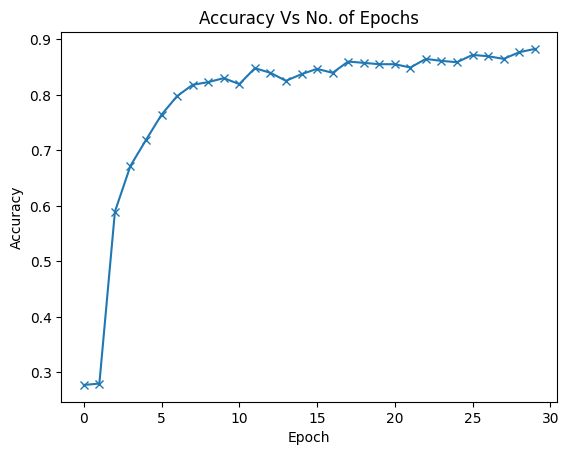

In [10]:
def plot_accuracies(history):
  accuracies = [x.cpu().item() for x in history['val_acc']]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Vs No. of Epochs")

plot_accuracies(history)

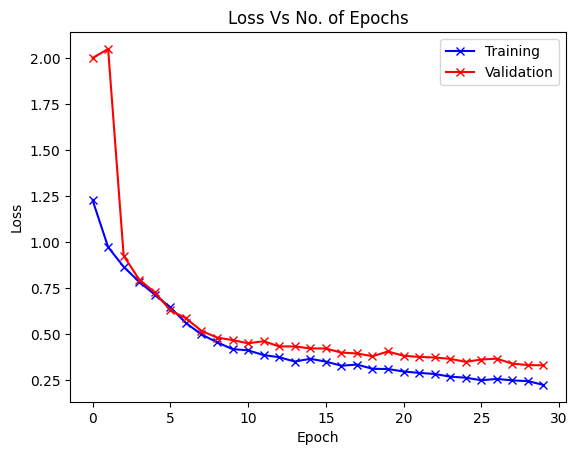

In [11]:
def plot_losses(history):
  train_losses = [x.cpu().item() for x in history['train_loss']]
  val_losses = [x.cpu().item() for x in history['val_loss']]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training','Validation'])
  plt.title("Loss Vs No. of Epochs")
plot_losses(history)

### Evaluate the model with the test set

evaluating...:   0%|          | 0/27 [00:00<?, ?it/s]

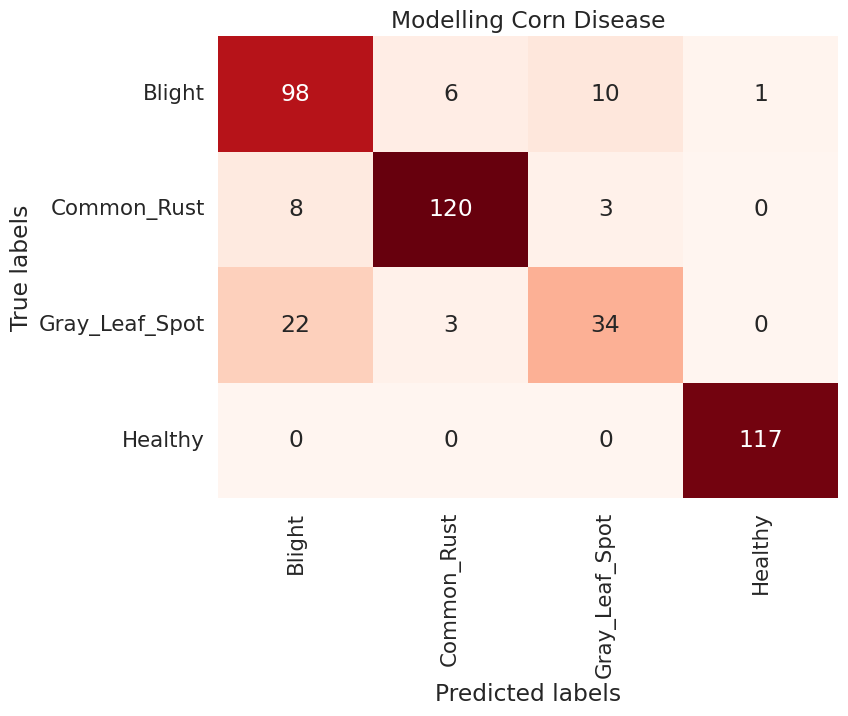

In [12]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(test_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Modelling Corn Disease')
plt.show()

## Additional testing on images with different backgrounds

evaluating...:   0%|          | 0/17 [00:00<?, ?it/s]

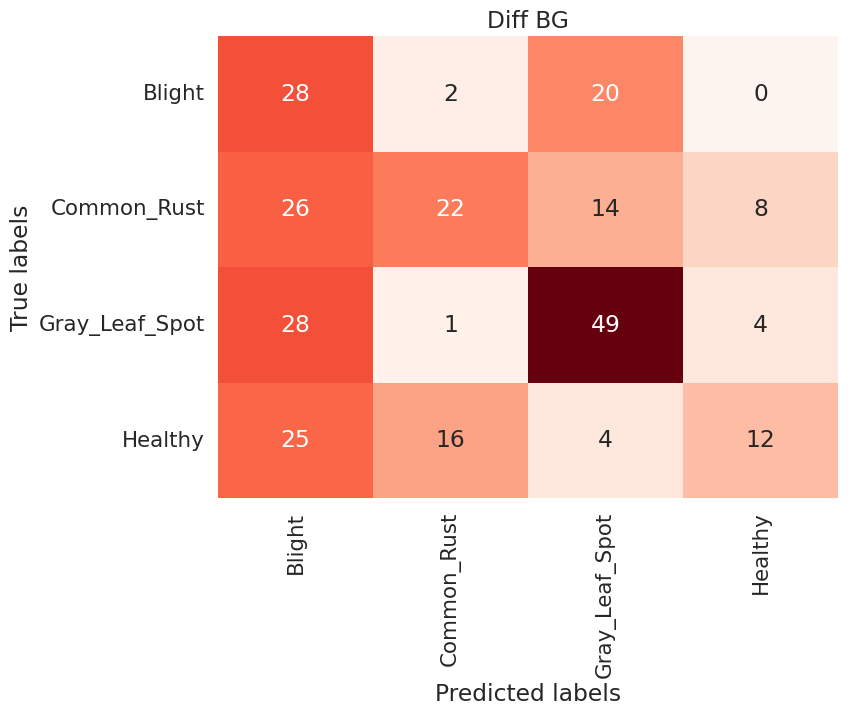

In [13]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(diffBg_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Diff BG')
plt.show()